In [36]:
import pandas as pd
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# load data 
df = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
# represent target (stock price) with log transformation for ease-of-use and plotting
df['log_stock_price'] = np.log(df['stock_price'])
# separate from raw differences to keep track of trends in the data
df['raw_change'] = df['stock_price'].diff()
df['log_change'] = df['log_stock_price'].diff()

# calculate net change in stock price per month 
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)
df['year_month'] = df['date'].dt.to_period('M')
month_means = df.groupby('year_month')['stock_price'].mean().reset_index()
month_changes = df.groupby('year_month')['log_change'].sum().reset_index()

# convert datetime column to continuous so that it can be worked with more easily, as done in the volcano sklearn example
df['date'] = pd.to_datetime(df['date'])
reference_date = df['date'].min()
df['days_since_start'] = (df['date'] - reference_date).dt.days

## CHUNK DATA FRAME BEFORE CROSS VALIDATION STEP - I WANT A HOLDOUT SET ##
from sklearn.model_selection import train_test_split

# Split -- for later use if we need to further partition for cross val! remember to postprocess this into numerical datetime format
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
## train_df.head()

# define data ## USING WHOLE TRAINING DATA FOR NOW
x = df['days_since_start']
y = df['log_stock_price']

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


datetime64[ns]


c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py", lin

Best Kernel: 1**2 * RationalQuadratic(alpha=1, length_scale=1)
Best Alpha (noise level): 1e-10
Best CV Score: 0.0012463471589983573


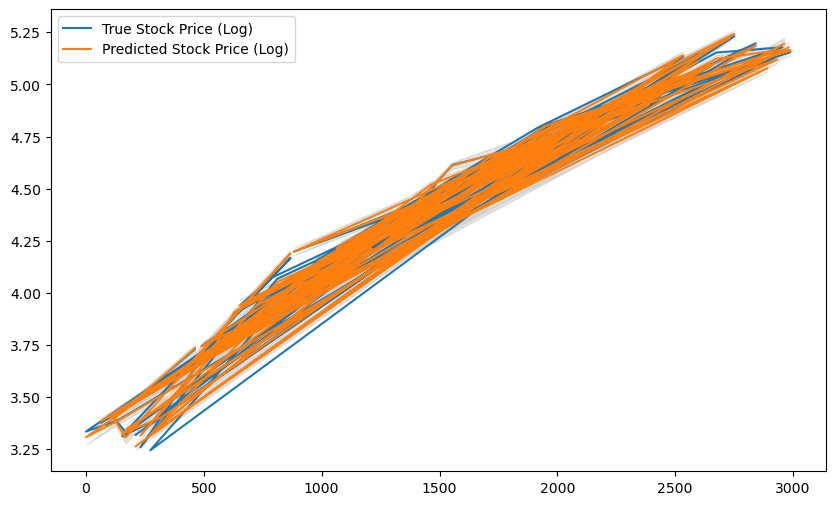

In [37]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.gaussian_process.kernels import ConstantKernel as C

# Define X_train, X_test, y_train, y_test (assuming you have already prepared this data)

# Define different kernels to test
kernel_options = [
    C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0),  # Radial Basis Function (RBF)
    C(1.0, (1e-2, 1e2)) * Matern(nu=1.5),         # Matern kernel (nu = 1.5)
    C(1.0, (1e-2, 1e2)) * RationalQuadratic(),     # Rational Quadratic kernel
    C(1.0, (1e-2, 1e2)) * ExpSineSquared(),        # Periodic kernel
    C(1.0, (1e-2, 1e2)) * DotProduct()             # Dot Product kernel
]

# Initialize a GaussianProcessRegressor
gpr = GaussianProcessRegressor()

# Set up the parameter grid to test different kernels
param_grid = {
    'kernel': kernel_options,
    'alpha': [1e-10, 1e-5, 1e-2],  # Noise level in the model
}

# TimeSeriesSplit ensures we do not shuffle the data, crucial for time series data
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV to perform cross-validation
grid_search = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model using the training data
grid_search.fit(X_train.values.reshape(-1, 1), y_train)

# Display the best parameters found
print("Best Kernel:", grid_search.best_params_['kernel'])
print("Best Alpha (noise level):", grid_search.best_params_['alpha'])
print("Best CV Score:", -grid_search.best_score_)

# Predict on the test set using the best model
best_gpr = grid_search.best_estimator_
y_pred, y_std = best_gpr.predict(X_test.values.reshape(-1, 1), return_std=True)

# Optional: Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test, label='True Stock Price (Log)')
plt.plot(X_test, y_pred, label='Predicted Stock Price (Log)')
plt.fill_between(X_test, y_pred - y_std, y_pred + y_std, color='gray', alpha=0.2)
plt.legend()
plt.show()


In [38]:
## REFERENCE: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html ##
##
##

# convert split data to tensors for pytorch
X_train = torch.tensor(X_train.values).float().unsqueeze(1)  # training x
y_train = torch.tensor(y_train.values).float()  # training y
X_test = torch.tensor(X_test.values).float().unsqueeze(1)  # testing x
y_test = torch.tensor(y_test.values).float()  # testing y

# define model class with constant mean and rbf kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train , y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model - gives a model instance with likelihood defined
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

## switch into training mode
# Find optimal model hyperparameters
model.train()
likelihood.train()

# 
training_iter = 50
# Use the adam optimizer with 0.1 learning rate and marginal likelihood loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 8.297   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 7.541   lengthscale: 0.693   noise: 0.744
Iter 3/50 - Loss: 6.879   lengthscale: 0.693   noise: 0.798
Iter 4/50 - Loss: 6.298   lengthscale: 0.693   noise: 0.853
Iter 5/50 - Loss: 5.791   lengthscale: 0.693   noise: 0.910
Iter 6/50 - Loss: 5.348   lengthscale: 0.693   noise: 0.968
Iter 7/50 - Loss: 4.961   lengthscale: 0.693   noise: 1.026
Iter 8/50 - Loss: 4.624   lengthscale: 0.693   noise: 1.085
Iter 9/50 - Loss: 4.328   lengthscale: 0.693   noise: 1.144
Iter 10/50 - Loss: 4.070   lengthscale: 0.693   noise: 1.202
Iter 11/50 - Loss: 3.843   lengthscale: 0.693   noise: 1.260
Iter 12/50 - Loss: 3.644   lengthscale: 0.693   noise: 1.316
Iter 13/50 - Loss: 3.468   lengthscale: 0.693   noise: 1.372
Iter 14/50 - Loss: 3.313   lengthscale: 0.693   noise: 1.425
Iter 15/50 - Loss: 3.176   lengthscale: 0.693   noise: 1.478
Iter 16/50 - Loss: 3.054   lengthscale: 0.693   noise: 1.528
Iter 17/50 - Loss: 2.945   length

In [39]:
model.eval()
likelihood.eval()

# Make predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the distribution of predictions
    test_dist = model(X_test)
    # Get mean predictions
    mean = test_dist.mean
    # Get predictive variance (uncertainty)
    lower, upper = test_dist.confidence_region()

# Print out or visualize results
print("Predicted means:", mean)
print("Lower bound of confidence interval:", lower)
print("Upper bound of confidence interval:", upper)

Predicted means: tensor([3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371,
        3.2371, 3.2371, 3.2371, 3.2371, 3.2371, 3.2371])
Lower bound of confidence interval: tensor([0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815,
        0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815,
        0.

<function matplotlib.pyplot.show(close=None, block=None)>

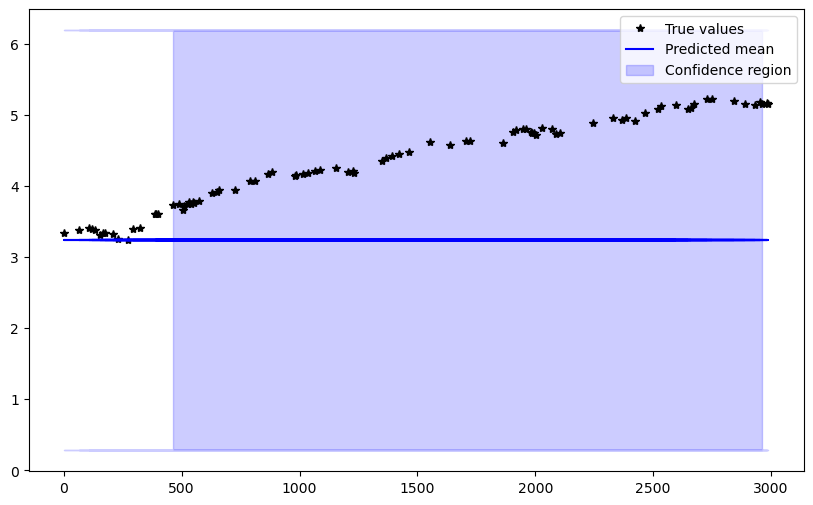

In [42]:
import matplotlib.pyplot as plt

# Plot the true values and predictions
plt.figure(figsize=(10, 6))

# Plot true values (y_test)
plt.plot(X_test.squeeze().numpy(), y_test.numpy(), 'k*', label='True values')

# Plot predicted means
plt.plot(X_test.squeeze().numpy(), mean.numpy(), 'b', label='Predicted mean')

# Plot uncertainty as shaded region
plt.fill_between(X_test.squeeze().numpy(), lower.numpy(), upper.numpy(), color='blue', alpha=0.2, label='Confidence region')

plt.legend()
plt.show



In [46]:
# smoke_test (this makes sure this example notebook gets tested)

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [47]:
raw_outputscale = model.covar_module.raw_outputscale
print('raw_outputscale, ', raw_outputscale)

# Three ways of accessing the raw outputscale constraint
print('\nraw_outputscale_constraint1', model.covar_module.raw_outputscale_constraint)

printmd('\n\n**Printing all model constraints...**\n')
for constraint_name, constraint in model.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')

printmd('\n**Getting raw outputscale constraint from model...**')
print(model.constraint_for_parameter_name("covar_module.raw_outputscale"))


printmd('\n**Getting raw outputscale constraint from model.covar_module...**')
print(model.covar_module.constraint_for_parameter_name("raw_outputscale"))

raw_outputscale,  Parameter containing:
tensor(0., requires_grad=True)

raw_outputscale_constraint1 Positive()




**Printing all model constraints...**


Constraint name: likelihood.noise_covar.raw_noise_constraint             constraint = GreaterThan(1.000E-04)
Constraint name: covar_module.raw_outputscale_constraint                 constraint = Positive()
Constraint name: covar_module.base_kernel.raw_lengthscale_constraint     constraint = Positive()



**Getting raw outputscale constraint from model...**

Positive()



**Getting raw outputscale constraint from model.covar_module...**

Positive()
